In [2]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from binance import Client
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import sys
import ta
from data import get_data
# sys.path.insert(1, '/Users/arsenchik/Desktop/dipploma/machine_learning_in_hft/algotrading/backtesting')
# from backtest import * 
# from strategies import *
# from config import *
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings("ignore")


In [66]:
url = config.DATABASE_URL_1MINUTE
time_frame = config.INTERVAL_1MINUTE
td_days = 0

In [8]:
client = Client()
engine = create_engine(url=url)

NameError: name 'url' is not defined

In [ ]:
symbol = 'BTCUSDT'
data = get_data(symbol)

In [68]:
# with engine.connect() as connection:
#     query = "SELECT name FROM sqlite_schema WHERE type='table'"
#     symbols = [item[0] for item in connection.execute(text(query)).fetchall()]
#     # for symbol in symbols:
#     #     qry = f"SELECT * FROM '{symbol}' WHERE Open_Time < '{pd.to_datetime('today') - timedelta(days = td_days)}'"
#     #     data = pd.DataFrame(connection.execute(text(qry))).set_index("Open_Time")
#     #     data.index = pd.to_datetime(data.index)
#     symbol = symbols[0]
#     qry = f"SELECT * FROM '{symbol}' WHERE Open_Time < '{pd.to_datetime('today') - timedelta(days = td_days)}'"
#     data = pd.DataFrame(connection.execute(text(qry))).set_index("Open_Time")
#     data.index = pd.to_datetime(data.index)

# connection.close()

# print(symbol)
# data

In [69]:
# data.plot(style='.',
#         figsize=(15, 5),
#         color=color_pal[0],
#         title='SOLUSDT')
# plt.show()

In [70]:
# fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

# fold = 0
# for train_idx, val_idx in tss.split(df):
#     train = data.iloc[train_idx]
#     test = data.iloc[val_idx]
#     train['Close'].plot(ax=axs[fold],
#                           label='Training Set',
#                           title=f'Data Train/Test Split Fold {fold}')
#     test['Close'].plot(ax=axs[fold],
#                          label='Test Set')
#     axs[fold].axvline(test.index.min(), color='black', ls='--')
#     fold += 1
# plt.show()

In [9]:
symbol = 'BTCUSDT'
data = get_data(symbol)

In [73]:
data.head()

,Open,High,Low,Close,Volume
Time,,,,,
2023-01-08 21:42:00,13.81,13.83,13.80,13.80,1661.56
2023-01-08 21:43:00,13.80,13.81,13.79,13.80,863.28
2023-01-08 21:44:00,13.79,13.81,13.79,13.80,1730.60
2023-01-08 21:45:00,13.80,13.83,13.79,13.81,4006.07
2023-01-08 21:46:00,13.82,13.84,13.81,13.81,6932.46


In [6]:
data.describe()

,Open,High,Low,Close,Volume
count,60001.000000,60001.000000,60001.000000,60001.000000,60001.000000
mean,22.409604,22.431721,22.387541,22.409084,5048.014101
std,2.644143,2.644212,2.642857,2.644272,10958.059426
min,13.690000,13.700000,13.680000,13.680000,0.430000
25%,21.300000,21.320000,21.280000,21.300000,984.360000
50%,23.300000,23.320000,23.280000,23.300000,2179.700000
75%,24.230000,24.260000,24.210000,24.230000,4965.260000
max,26.720000,26.800000,26.600000,26.720000,518938.220000


In [78]:
data.tail()

,Open,High,Low,Close,Volume
Time,,,,,
2023-02-19 13:38:00,24.16,24.17,24.16,24.16,831.14
2023-02-19 13:39:00,24.16,24.16,24.11,24.12,4492.28
2023-02-19 13:40:00,24.12,24.17,24.12,24.17,2911.56
2023-02-19 13:41:00,24.18,24.25,24.17,24.23,2543.12
2023-02-19 13:42:00,24.24,24.25,24.18,24.24,15519.17


In [9]:
def indicators_calc(df):
    for i in range(2, 10, 2):
        df[f'RSI_{i}'] = ta.momentum.rsi(df['Close'], window=i)
        df[f'SMA_{i*10}'] = df['Close'].rolling(i*10).mean()
    # df['MACD'] = ta.trend.macd_diff(df['Close'])
    df.dropna(inplace=True)
    return df

In [10]:
data = indicators_calc(data)
data.head()

NameError: name 'indicators_calc' is not defined

In [21]:
def create_target(df, period):
    df['Target'] = df['Close'].shift(-period) - df['Close']
    df = df[:-period]
    return df

In [22]:
data = create_target(data, 1)
data.tail()

,Open,High,Low,Close,Volume,RSI_2,SMA_20,RSI_4,SMA_40,RSI_6,SMA_60,RSI_8,SMA_80,Target
Time,,,,,,,,,,,,,,
2023-02-19 11:29:00,23.69,23.69,23.65,23.66,7145.71,50.933152,23.6025,65.786738,23.59700,68.097693,23.593167,67.890349,23.589875,0.01
2023-02-19 11:30:00,23.66,23.68,23.65,23.67,1897.92,67.016656,23.6080,71.293622,23.59825,71.637786,23.594000,70.667750,23.591500,-0.02
2023-02-19 11:31:00,23.67,23.67,23.63,23.65,2522.00,28.997099,23.6125,49.882879,23.59925,56.571627,23.595167,59.002471,23.593000,0.02
2023-02-19 11:32:00,23.65,23.67,23.64,23.67,603.33,66.737609,23.6175,64.212888,23.60100,65.323112,23.596833,65.509280,23.594750,0.00
2023-02-19 11:33:00,23.67,23.68,23.66,23.67,639.05,66.737609,23.6215,64.212888,23.60275,65.323112,23.598500,65.509280,23.596500,-0.01


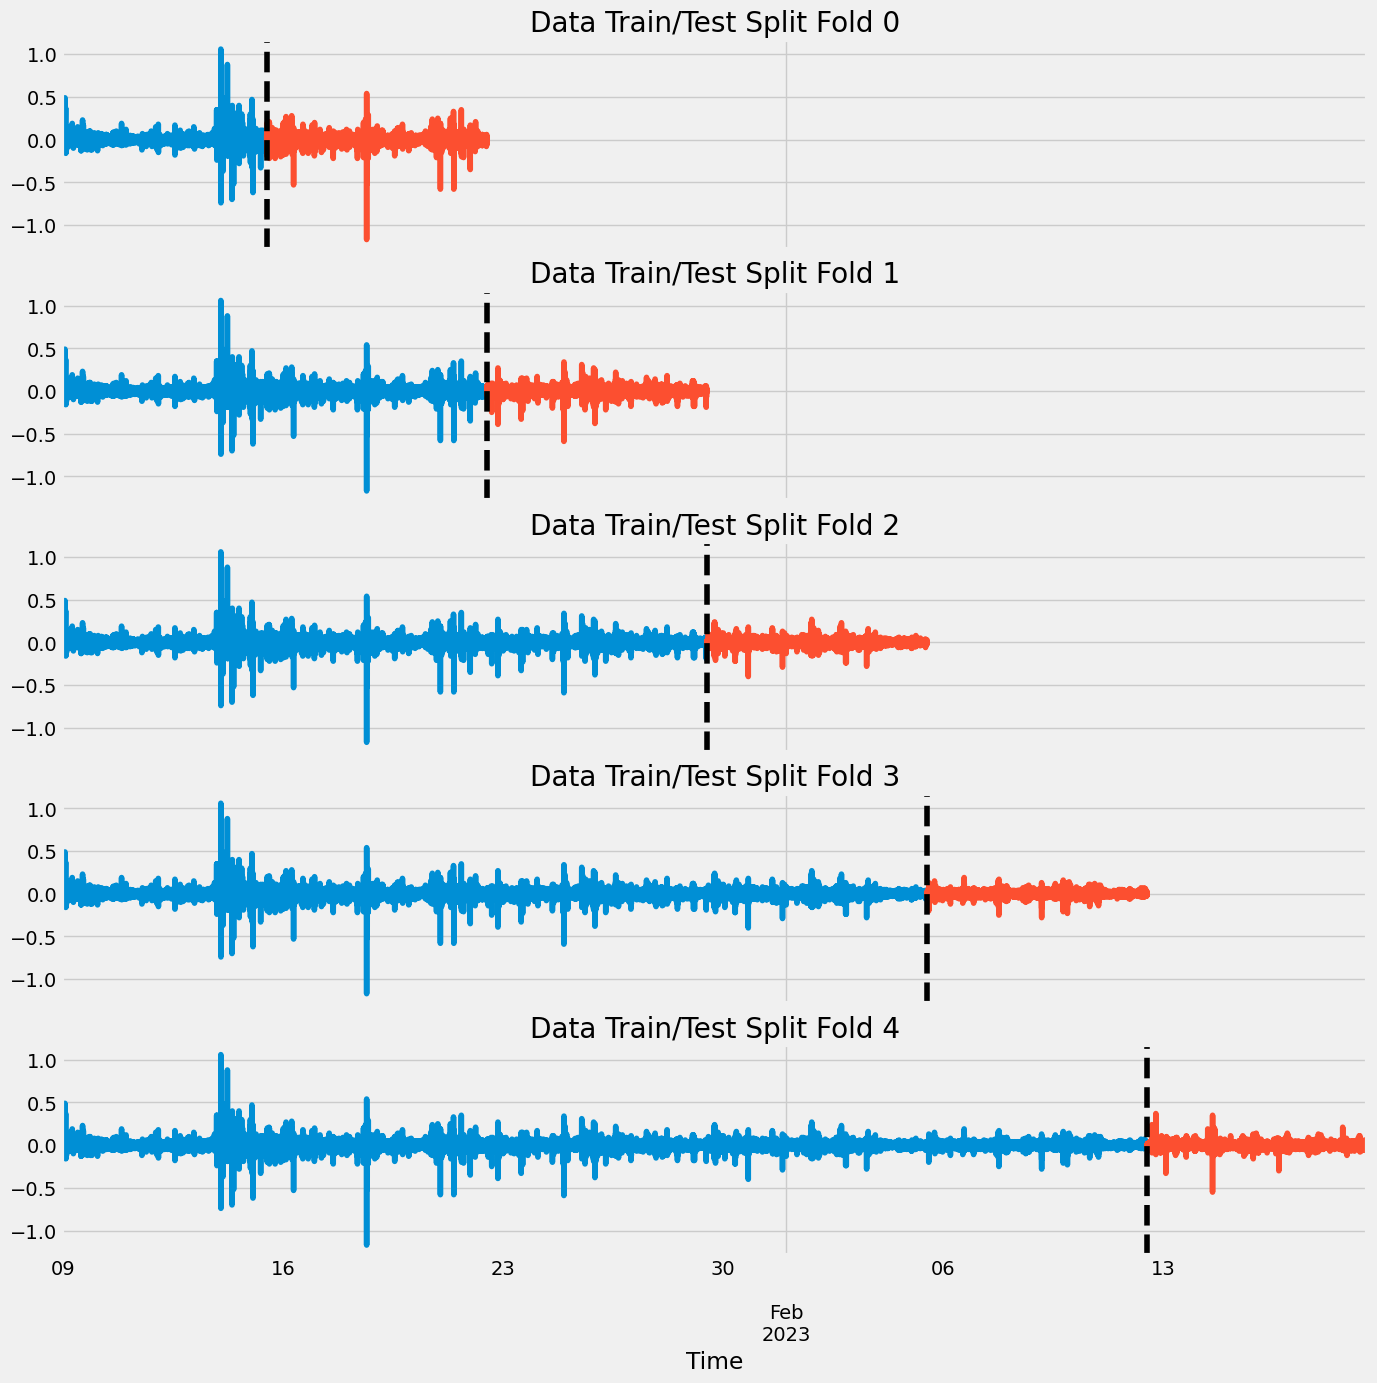

In [24]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=7*24*60)
data = data.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(data):
    train = data.iloc[train_idx]
    test = data.iloc[val_idx]
    train['Target'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['Target'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [37]:
FEATURES = ['Open',
    'High',
    'Low',
    'Volume',
    'RSI_2',
    'SMA_20',
    'RSI_4',
    'SMA_40',
    'RSI_6',
    'SMA_60',
    'RSI_8',
    'SMA_80']
TARGET = 'Target'

## Train using CV

In [59]:
tss = TimeSeriesSplit(n_splits=5, test_size=3*24*60)
data = data.sort_index()

fold = 0
preds = []
scores = []

for train_idx, val_idx in tss.split(data):
    train = data.iloc[train_idx]
    test = data.iloc[val_idx]

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[15:48:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.49643	validation_1-rmse:0.49575
[100]	validation_0-rmse:0.18562	validation_1-rmse:0.18304
[200]	validation_0-rmse:0.07771	validation_1-rmse:0.07051
[300]	validation_0-rmse:0.04717	validation_1-rmse:0.03347
[400]	validation_0-rmse:0.04131	validation_1-rmse:0.02450
[500]	validation_0-rmse:0.04037	validation_1-rmse:0.02311
[600]	validation_0-rmse:0.04016	validation_1-rmse:0.02297
[659]	validation_0-rmse:0.04008	validation_1-rmse:0.02296
[15:48:48] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.49636	validation_1-rmse:0.49645
[100]	validation_0-rmse:0.18531	validation_1-rmse:0.18

In [60]:
print(f'RMSE score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

RMSE score across folds 0.0261
Fold scores:[0.0229590155913538, 0.02916313022780002, 0.025893708207128236, 0.028587283796661735, 0.02391721991717501]


In [63]:
reg = xgb.XGBRegressor(booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
reg.fit(data[FEATURES], data[TARGET],
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[15:49:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.49622	validation_1-rmse:0.49557
[100]	validation_0-rmse:0.18485	validation_1-rmse:0.18282
[200]	validation_0-rmse:0.07582	validation_1-rmse:0.07058
[300]	validation_0-rmse:0.04400	validation_1-rmse:0.03412
[400]	validation_0-rmse:0.03768	validation_1-rmse:0.02548
[500]	validation_0-rmse:0.03668	validation_1-rmse:0.02406
[600]	validation_0-rmse:0.03649	validation_1-rmse:0.02385
[700]	validation_0-rmse:0.03639	validation_1-rmse:0.02381
[800]	validation_0-rmse:0.03631	validation_1-rmse:0.02379
[900]	validation_0-rmse:0.03623	validation_1-rmse:0.02378
[999]	validation_0-rmse:0.03614	validation_1-rmse:0.02377


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [64]:
y_pred = reg.predict(data[FEATURES])
score = r2_score(data[TARGET].values, y_pred)
print(score)

0.054428472485202106


In [57]:
y_pred

array([ 0.01017421,  0.01059893,  0.01082131, ...,  0.00047217,
       -0.0007667 , -0.0007667 ], dtype=float32)

In [58]:
data[TARGET].values

array([-0.01, -0.02,  0.02, ...,  0.02,  0.  , -0.01])

In [11]:
import yaml
config_file = "metrics.yaml"
try: 
    with open (config_file, 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print('Error reading the config file')

In [12]:
config

{'regression': ['mse', 'mae', 'r_2'],
 'classification': ['log_loss', 'accuracy', 'auc', 'f1'],
 'mse': {'full_name': 'Mean Squared Error', 'abbr': 'MSE', 'objective': 'min'},
 'mae': {'full_name': 'Mean Absolute Error',
  'abbr': 'MAE',
  'objective': 'min'},
 'msle': {'full_name': 'Mean Squared Logarithmic Error',
  'abbr': 'MSLE',
  'objective': 'min'},
 'poisson': {'full_name': 'Poisson Loss',
  'abbr': 'Poisson Loss',
  'objective': 'min'},
 'r_2': {'full_name': 'R²', 'abbr': 'R²', 'objective': 'max'},
 'log_loss': {'full_name': 'Log Loss', 'abbr': 'Log Loss', 'objective': 'min'},
 'categorical_crossentropy': {'full_name': 'Categorical Loss',
  'abbr': 'Categorical Loss',
  'objective': 'min'},
 'binary_crossentropy': {'full_name': 'Binary Loss',
  'abbr': 'Binary Loss',
  'objective': 'min'},
 'accuracy': {'full_name': 'Accuracy',
  'abbr': 'Accuracy',
  'objective': 'max',
  'format': 'percent'},
 'precision': {'full_name': 'Precision',
  'abbr': 'Precision',
  'objective': 'max

In [ ]:
param_grid = {
    # "device_type": trial.suggest_categorical("device_type", ['gpu']),
    "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
    "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
    "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
    "max_depth": trial.suggest_int("max_depth", 3, 12),
    "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
    "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
    "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
    "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
    "bagging_fraction": trial.suggest_float(
        "bagging_fraction", 0.2, 0.95, step=0.1
    ),
    "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
    "feature_fraction": trial.suggest_float(
        "feature_fraction", 0.2, 0.95, step=0.1
    ),
}

In [34]:
params_dict = {"best_parameters": { 'num_epochs': 5000, 'batch_size': 32, 'learning_rate': 0.01, 'optimizer': 'Adam' }}

In [40]:
with open('best_parameters.yaml', 'w') as outfile: 
    yaml.dump(params_dict, outfile, default_flow_style=False)

In [5]:
import pandas as pd
from model import *
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv('data.csv')
df.set_index("Time", inplace=True)
model = Model(df, model_name="LightGBM", task_type="classification")

In [6]:
model.indicators_calc()
model.create_target()
model.optimize('/Users/arsenchik/Desktop/dipploma/machine_learning_in_hft/algotrading/model_training/optimization_results')

  0%|          | 0/4 [00:00<?, ?it/s][I 2023-02-20 01:16:09,072] A new study created in memory with name: classification LightGBM with metric - log_loss


{'LightGBM': {'n_estimators': ('suggest_int', ('LightGBM_n_estimators', 50, 1000)), 'learning_rate': ('suggest_float', ('LightGBM_learning_rate', 0.01, 0.3)), 'num_leaves': ('suggest_int', ('LightGBM_num_leaves', 20, 3000, 20)), 'max_depth': ('suggest_int', ('LightGBM_max_depth', 3, 12)), 'min_data_in_leaf': ('suggest_int', ('LightGBM_min_data_in_leaf', 200, 10000, 100)), 'lambda_l1': ('suggest_int', ('LightGBM_lambda_l1', 0, 100, 5)), 'lambda_l2': ('suggest_int', ('LightGBM_lambda_l2', 0, 100, 5)), 'min_gain_to_split': ('suggest_float', ('LightGBM_min_gain_to_split', 0, 15)), 'bagging_fraction': ('suggest_float', ('LightGBM_bagging_fraction', 0.2, 0.95, 0.1)), 'bagging_freq': ('suggest_categorical', ('LightGBM_bagging_freq', [1])), 'feature_fraction': ('suggest_float', ('LightGBM_feature_fraction', 0.2, 0.95, 0.1))}}
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=2100, min_child_s

[I 2023-02-20 01:16:09,821] Trial 0 finished with value: 17.817579325353577 and parameters: {'LightGBM_n_estimators': 287, 'LightGBM_learning_rate': 0.16994824017207438, 'LightGBM_num_leaves': 1120, 'LightGBM_max_depth': 10, 'LightGBM_min_data_in_leaf': 2100, 'LightGBM_lambda_l1': 70, 'LightGBM_lambda_l2': 90, 'LightGBM_min_gain_to_split': 4.499802685915041, 'LightGBM_bagging_fraction': 0.5, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.7}. Best is trial 0 with value: 17.817579325353577.


[7]	valid_0's binary_logloss: 0.692886
[8]	valid_0's binary_logloss: 0.692838
[9]	valid_0's binary_logloss: 0.692838
[10]	valid_0's binary_logloss: 0.692838
[11]	valid_0's binary_logloss: 0.692838
[12]	valid_0's binary_logloss: 0.69279
[13]	valid_0's binary_logloss: 0.692786
[14]	valid_0's binary_logloss: 0.692774
[15]	valid_0's binary_logloss: 0.692774
[16]	valid_0's binary_logloss: 0.692774
[17]	valid_0's binary_logloss: 0.692743
[18]	valid_0's binary_logloss: 0.692743
[19]	valid_0's binary_logloss: 0.692741
[20]	valid_0's binary_logloss: 0.692741
[21]	valid_0's binary_logloss: 0.692741
[22]	valid_0's binary_logloss: 0.692741
[23]	valid_0's binary_logloss: 0.692741
[24]	valid_0's binary_logloss: 0.692741
[25]	valid_0's binary_logloss: 0.692741
[26]	valid_0's binary_logloss: 0.692741
[27]	valid_0's binary_logloss: 0.692741
[28]	valid_0's binary_logloss: 0.692741
[29]	valid_0's binary_logloss: 0.692741
[30]	valid_0's binary_logloss: 0.692741
[31]	valid_0's binary_logloss: 0.692741
[32]

[I 2023-02-20 01:16:10,611] Trial 1 finished with value: 17.886662994349383 and parameters: {'LightGBM_n_estimators': 779, 'LightGBM_learning_rate': 0.075025984658074, 'LightGBM_num_leaves': 1640, 'LightGBM_max_depth': 12, 'LightGBM_min_data_in_leaf': 2500, 'LightGBM_lambda_l1': 80, 'LightGBM_lambda_l2': 45, 'LightGBM_min_gain_to_split': 7.177205235123378, 'LightGBM_bagging_fraction': 0.8, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.8}. Best is trial 0 with value: 17.817579325353577.


[77]	valid_0's binary_logloss: 0.692725
[78]	valid_0's binary_logloss: 0.692725
[79]	valid_0's binary_logloss: 0.692725
[80]	valid_0's binary_logloss: 0.692725
[81]	valid_0's binary_logloss: 0.692725
[82]	valid_0's binary_logloss: 0.692725
[83]	valid_0's binary_logloss: 0.692725
[84]	valid_0's binary_logloss: 0.692725
[85]	valid_0's binary_logloss: 0.692725
[86]	valid_0's binary_logloss: 0.692725
[87]	valid_0's binary_logloss: 0.692725
[88]	valid_0's binary_logloss: 0.692725
[89]	valid_0's binary_logloss: 0.692725
[90]	valid_0's binary_logloss: 0.692725
[91]	valid_0's binary_logloss: 0.692725
[92]	valid_0's binary_logloss: 0.692725
[93]	valid_0's binary_logloss: 0.692725
[94]	valid_0's binary_logloss: 0.692725
[95]	valid_0's binary_logloss: 0.692725
[96]	valid_0's binary_logloss: 0.692725
[97]	valid_0's binary_logloss: 0.692725
[98]	valid_0's binary_logloss: 0.692725
[99]	valid_0's binary_logloss: 0.692725
[100]	valid_0's binary_logloss: 0.692725
[101]	valid_0's binary_logloss: 0.69272

[I 2023-02-20 01:16:11,286] Trial 2 finished with value: 17.900679970667376 and parameters: {'LightGBM_n_estimators': 340, 'LightGBM_learning_rate': 0.07321321352069063, 'LightGBM_num_leaves': 2520, 'LightGBM_max_depth': 9, 'LightGBM_min_data_in_leaf': 8600, 'LightGBM_lambda_l1': 80, 'LightGBM_lambda_l2': 70, 'LightGBM_min_gain_to_split': 10.58432048668431, 'LightGBM_bagging_fraction': 0.7, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.30000000000000004}. Best is trial 0 with value: 17.817579325353577.


[153]	valid_0's binary_logloss: 0.692894
[154]	valid_0's binary_logloss: 0.692894
[155]	valid_0's binary_logloss: 0.692894
[156]	valid_0's binary_logloss: 0.692894
[157]	valid_0's binary_logloss: 0.692894
[158]	valid_0's binary_logloss: 0.692894
[159]	valid_0's binary_logloss: 0.692894
[160]	valid_0's binary_logloss: 0.692894
[161]	valid_0's binary_logloss: 0.692894
[162]	valid_0's binary_logloss: 0.692894
[163]	valid_0's binary_logloss: 0.692894
[164]	valid_0's binary_logloss: 0.692894
[165]	valid_0's binary_logloss: 0.692894
[166]	valid_0's binary_logloss: 0.692894
[167]	valid_0's binary_logloss: 0.692894
[168]	valid_0's binary_logloss: 0.692894
[169]	valid_0's binary_logloss: 0.692894
[170]	valid_0's binary_logloss: 0.692894
[171]	valid_0's binary_logloss: 0.692894
[172]	valid_0's binary_logloss: 0.692894
[173]	valid_0's binary_logloss: 0.692894
[174]	valid_0's binary_logloss: 0.692894
[175]	valid_0's binary_logloss: 0.692894
[176]	valid_0's binary_logloss: 0.692894
[177]	valid_0's 

[I 2023-02-20 01:16:11,913] Trial 3 finished with value: 17.726468979286643 and parameters: {'LightGBM_n_estimators': 555, 'LightGBM_learning_rate': 0.2657721829207927, 'LightGBM_num_leaves': 2740, 'LightGBM_max_depth': 7, 'LightGBM_min_data_in_leaf': 1500, 'LightGBM_lambda_l1': 70, 'LightGBM_lambda_l2': 45, 'LightGBM_min_gain_to_split': 11.225883361780998, 'LightGBM_bagging_fraction': 0.4, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.4}. Best is trial 3 with value: 17.726468979286643.


[136]	valid_0's binary_logloss: 0.692827
[137]	valid_0's binary_logloss: 0.692827
[138]	valid_0's binary_logloss: 0.692827
[139]	valid_0's binary_logloss: 0.692827
[140]	valid_0's binary_logloss: 0.692827
[141]	valid_0's binary_logloss: 0.692827
[142]	valid_0's binary_logloss: 0.692827
[143]	valid_0's binary_logloss: 0.692827
[144]	valid_0's binary_logloss: 0.692827
[145]	valid_0's binary_logloss: 0.692827
[146]	valid_0's binary_logloss: 0.692827
[147]	valid_0's binary_logloss: 0.692827
[148]	valid_0's binary_logloss: 0.692827
[149]	valid_0's binary_logloss: 0.692827
[150]	valid_0's binary_logloss: 0.692827
[151]	valid_0's binary_logloss: 0.692827
[152]	valid_0's binary_logloss: 0.692827
[153]	valid_0's binary_logloss: 0.692827
[154]	valid_0's binary_logloss: 0.692827
[155]	valid_0's binary_logloss: 0.692827
[156]	valid_0's binary_logloss: 0.692827
[157]	valid_0's binary_logloss: 0.692827
[158]	valid_0's binary_logloss: 0.692827
[159]	valid_0's binary_logloss: 0.692827
[160]	valid_0's 

[I 2023-02-20 01:16:12,454] Trial 4 finished with value: 17.87464844321968 and parameters: {'LightGBM_n_estimators': 501, 'LightGBM_learning_rate': 0.2727902295017356, 'LightGBM_num_leaves': 700, 'LightGBM_max_depth': 10, 'LightGBM_min_data_in_leaf': 9000, 'LightGBM_lambda_l1': 60, 'LightGBM_lambda_l2': 65, 'LightGBM_min_gain_to_split': 10.506872495259337, 'LightGBM_bagging_fraction': 0.5, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.5}. Best is trial 3 with value: 17.726468979286643.


[2]	valid_0's binary_logloss: 0.693307
[3]	valid_0's binary_logloss: 0.693307
[4]	valid_0's binary_logloss: 0.693307
[5]	valid_0's binary_logloss: 0.693234
[6]	valid_0's binary_logloss: 0.693234
[7]	valid_0's binary_logloss: 0.693234
[8]	valid_0's binary_logloss: 0.693173
[9]	valid_0's binary_logloss: 0.693173
[10]	valid_0's binary_logloss: 0.693173
[11]	valid_0's binary_logloss: 0.693173
[12]	valid_0's binary_logloss: 0.693173
[13]	valid_0's binary_logloss: 0.693173
[14]	valid_0's binary_logloss: 0.693173
[15]	valid_0's binary_logloss: 0.693173
[16]	valid_0's binary_logloss: 0.693173
[17]	valid_0's binary_logloss: 0.693173
[18]	valid_0's binary_logloss: 0.693173
[19]	valid_0's binary_logloss: 0.693173
[20]	valid_0's binary_logloss: 0.693173
[21]	valid_0's binary_logloss: 0.693173
[22]	valid_0's binary_logloss: 0.693173
[23]	valid_0's binary_logloss: 0.693173
[24]	valid_0's binary_logloss: 0.693173
[25]	valid_0's binary_logloss: 0.693173
[26]	valid_0's binary_logloss: 0.693173
[27]	val

[I 2023-02-20 01:16:13,826] Trial 5 finished with value: 17.72046170372179 and parameters: {'LightGBM_n_estimators': 671, 'LightGBM_learning_rate': 0.06087256073385815, 'LightGBM_num_leaves': 1140, 'LightGBM_max_depth': 5, 'LightGBM_min_data_in_leaf': 2500, 'LightGBM_lambda_l1': 60, 'LightGBM_lambda_l2': 5, 'LightGBM_min_gain_to_split': 1.1368601467310873, 'LightGBM_bagging_fraction': 0.8, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.5}. Best is trial 5 with value: 17.72046170372179.


[73]	valid_0's binary_logloss: 0.692776
[74]	valid_0's binary_logloss: 0.692775
[75]	valid_0's binary_logloss: 0.692775
[76]	valid_0's binary_logloss: 0.692775
[77]	valid_0's binary_logloss: 0.692768
[78]	valid_0's binary_logloss: 0.692776
[79]	valid_0's binary_logloss: 0.692776
[80]	valid_0's binary_logloss: 0.692779
[81]	valid_0's binary_logloss: 0.692783
[82]	valid_0's binary_logloss: 0.692782
[83]	valid_0's binary_logloss: 0.692782
[84]	valid_0's binary_logloss: 0.692782
[85]	valid_0's binary_logloss: 0.692782
[86]	valid_0's binary_logloss: 0.692782
[87]	valid_0's binary_logloss: 0.692786
[88]	valid_0's binary_logloss: 0.692786
[89]	valid_0's binary_logloss: 0.692789
[90]	valid_0's binary_logloss: 0.692789
[91]	valid_0's binary_logloss: 0.692789
[92]	valid_0's binary_logloss: 0.692789
[93]	valid_0's binary_logloss: 0.692789
[94]	valid_0's binary_logloss: 0.692789
[95]	valid_0's binary_logloss: 0.692789
[96]	valid_0's binary_logloss: 0.692794
[97]	valid_0's binary_logloss: 0.692794


[I 2023-02-20 01:16:14,252] Trial 6 finished with value: 18.200042536315873 and parameters: {'LightGBM_n_estimators': 933, 'LightGBM_learning_rate': 0.06098382357177194, 'LightGBM_num_leaves': 1260, 'LightGBM_max_depth': 5, 'LightGBM_min_data_in_leaf': 7800, 'LightGBM_lambda_l1': 65, 'LightGBM_lambda_l2': 35, 'LightGBM_min_gain_to_split': 4.579899095459559, 'LightGBM_bagging_fraction': 0.2, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.5}. Best is trial 5 with value: 17.72046170372179.


[83]	valid_0's binary_logloss: 0.693707
[84]	valid_0's binary_logloss: 0.693707
[85]	valid_0's binary_logloss: 0.693707
[86]	valid_0's binary_logloss: 0.693707
[87]	valid_0's binary_logloss: 0.693707
[88]	valid_0's binary_logloss: 0.693707
[89]	valid_0's binary_logloss: 0.693707
[90]	valid_0's binary_logloss: 0.693707
[91]	valid_0's binary_logloss: 0.693707
[92]	valid_0's binary_logloss: 0.693707
[93]	valid_0's binary_logloss: 0.693707
[94]	valid_0's binary_logloss: 0.693707
[95]	valid_0's binary_logloss: 0.693707
[96]	valid_0's binary_logloss: 0.693707
[97]	valid_0's binary_logloss: 0.693707
[98]	valid_0's binary_logloss: 0.693707
[99]	valid_0's binary_logloss: 0.693707
[100]	valid_0's binary_logloss: 0.693707
[101]	valid_0's binary_logloss: 0.693707
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=7800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7800
[Lig

[I 2023-02-20 01:16:15,103] Trial 7 finished with value: 17.633356208031422 and parameters: {'LightGBM_n_estimators': 642, 'LightGBM_learning_rate': 0.11216769859122865, 'LightGBM_num_leaves': 2620, 'LightGBM_max_depth': 7, 'LightGBM_min_data_in_leaf': 800, 'LightGBM_lambda_l1': 45, 'LightGBM_lambda_l2': 10, 'LightGBM_min_gain_to_split': 2.753440236529594, 'LightGBM_bagging_fraction': 0.4, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.30000000000000004}. Best is trial 7 with value: 17.633356208031422.


[1]	valid_0's binary_logloss: 0.693155
[2]	valid_0's binary_logloss: 0.693074
[3]	valid_0's binary_logloss: 0.693012
[4]	valid_0's binary_logloss: 0.692987
[5]	valid_0's binary_logloss: 0.692922
[6]	valid_0's binary_logloss: 0.692874
[7]	valid_0's binary_logloss: 0.692847
[8]	valid_0's binary_logloss: 0.692799
[9]	valid_0's binary_logloss: 0.692828
[10]	valid_0's binary_logloss: 0.692809
[11]	valid_0's binary_logloss: 0.692809
[12]	valid_0's binary_logloss: 0.692797
[13]	valid_0's binary_logloss: 0.692782
[14]	valid_0's binary_logloss: 0.692782
[15]	valid_0's binary_logloss: 0.692738
[16]	valid_0's binary_logloss: 0.692733
[17]	valid_0's binary_logloss: 0.692733
[18]	valid_0's binary_logloss: 0.692731
[19]	valid_0's binary_logloss: 0.692743
[20]	valid_0's binary_logloss: 0.692743
[21]	valid_0's binary_logloss: 0.692729
[22]	valid_0's binary_logloss: 0.692729
[23]	valid_0's binary_logloss: 0.692729
[24]	valid_0's binary_logloss: 0.692729
[25]	valid_0's binary_logloss: 0.692729
[26]	vali

[I 2023-02-20 01:16:15,705] Trial 8 finished with value: 17.71745806593936 and parameters: {'LightGBM_n_estimators': 142, 'LightGBM_learning_rate': 0.10318041668185547, 'LightGBM_num_leaves': 2980, 'LightGBM_max_depth': 12, 'LightGBM_min_data_in_leaf': 7900, 'LightGBM_lambda_l1': 30, 'LightGBM_lambda_l2': 75, 'LightGBM_min_gain_to_split': 10.65801943912348, 'LightGBM_bagging_fraction': 0.6000000000000001, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.7}. Best is trial 7 with value: 17.633356208031422.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=7900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7900
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=10.65801943912348, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10.65801943912348
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[1]	valid_0's binary_logloss: 0.693154
[2]	valid_0's binary_logloss: 0.693107
[3]	valid_0's binary_logloss: 0.693041
[4]	valid_0's binary_lo

[I 2023-02-20 01:16:16,234] Trial 9 finished with value: 17.816578112759437 and parameters: {'LightGBM_n_estimators': 731, 'LightGBM_learning_rate': 0.28179715084480667, 'LightGBM_num_leaves': 360, 'LightGBM_max_depth': 12, 'LightGBM_min_data_in_leaf': 9500, 'LightGBM_lambda_l1': 65, 'LightGBM_lambda_l2': 30, 'LightGBM_min_gain_to_split': 3.332396647129131, 'LightGBM_bagging_fraction': 0.7, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.6000000000000001}. Best is trial 7 with value: 17.633356208031422.
 25%|██▌       | 1/4 [00:07<00:21,  7.16s/it][I 2023-02-20 01:16:16,237] A new study created in memory with name: classification LightGBM with metric - accuracy


[46]	valid_0's binary_logloss: 0.692722
[47]	valid_0's binary_logloss: 0.69278
[48]	valid_0's binary_logloss: 0.69278
[49]	valid_0's binary_logloss: 0.69278
[50]	valid_0's binary_logloss: 0.69278
[51]	valid_0's binary_logloss: 0.69278
[52]	valid_0's binary_logloss: 0.69278
[53]	valid_0's binary_logloss: 0.69278
[54]	valid_0's binary_logloss: 0.69278
[55]	valid_0's binary_logloss: 0.69278
[56]	valid_0's binary_logloss: 0.69278
[57]	valid_0's binary_logloss: 0.69278
[58]	valid_0's binary_logloss: 0.69278
[59]	valid_0's binary_logloss: 0.69278
[60]	valid_0's binary_logloss: 0.69278
[61]	valid_0's binary_logloss: 0.69278
[62]	valid_0's binary_logloss: 0.69278
[63]	valid_0's binary_logloss: 0.69278
[64]	valid_0's binary_logloss: 0.69278
[65]	valid_0's binary_logloss: 0.69278
[66]	valid_0's binary_logloss: 0.69278
[67]	valid_0's binary_logloss: 0.69278
[68]	valid_0's binary_logloss: 0.69278
[69]	valid_0's binary_logloss: 0.69278
[70]	valid_0's binary_logloss: 0.69278
[71]	valid_0's binary_lo

[I 2023-02-20 01:16:16,744] Trial 0 finished with value: 0.5075277777777778 and parameters: {'LightGBM_n_estimators': 462, 'LightGBM_learning_rate': 0.2984486104234101, 'LightGBM_num_leaves': 1380, 'LightGBM_max_depth': 10, 'LightGBM_min_data_in_leaf': 1200, 'LightGBM_lambda_l1': 95, 'LightGBM_lambda_l2': 85, 'LightGBM_min_gain_to_split': 8.549842473154191, 'LightGBM_bagging_fraction': 0.6000000000000001, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.9}. Best is trial 0 with value: 0.5075277777777778.


[71]	valid_0's binary_logloss: 0.692857
[72]	valid_0's binary_logloss: 0.692857
[73]	valid_0's binary_logloss: 0.692857
[74]	valid_0's binary_logloss: 0.692857
[75]	valid_0's binary_logloss: 0.692857
[76]	valid_0's binary_logloss: 0.692857
[77]	valid_0's binary_logloss: 0.692857
[78]	valid_0's binary_logloss: 0.692857
[79]	valid_0's binary_logloss: 0.692857
[80]	valid_0's binary_logloss: 0.692857
[81]	valid_0's binary_logloss: 0.692857
[82]	valid_0's binary_logloss: 0.692857
[83]	valid_0's binary_logloss: 0.692857
[84]	valid_0's binary_logloss: 0.692857
[85]	valid_0's binary_logloss: 0.692857
[86]	valid_0's binary_logloss: 0.692857
[87]	valid_0's binary_logloss: 0.692857
[88]	valid_0's binary_logloss: 0.692857
[89]	valid_0's binary_logloss: 0.692857
[90]	valid_0's binary_logloss: 0.692857
[91]	valid_0's binary_logloss: 0.692857
[92]	valid_0's binary_logloss: 0.692857
[93]	valid_0's binary_logloss: 0.692857
[94]	valid_0's binary_logloss: 0.692857
[95]	valid_0's binary_logloss: 0.692857


[I 2023-02-20 01:16:18,299] Trial 1 finished with value: 0.5065833333333334 and parameters: {'LightGBM_n_estimators': 760, 'LightGBM_learning_rate': 0.02638145835996214, 'LightGBM_num_leaves': 600, 'LightGBM_max_depth': 3, 'LightGBM_min_data_in_leaf': 2100, 'LightGBM_lambda_l1': 65, 'LightGBM_lambda_l2': 90, 'LightGBM_min_gain_to_split': 4.870139545076126, 'LightGBM_bagging_fraction': 0.2, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.7}. Best is trial 0 with value: 0.5075277777777778.


[512]	valid_0's binary_logloss: 0.692953
[513]	valid_0's binary_logloss: 0.692953
[514]	valid_0's binary_logloss: 0.692953
[515]	valid_0's binary_logloss: 0.692953
[516]	valid_0's binary_logloss: 0.692953
[517]	valid_0's binary_logloss: 0.692953
[518]	valid_0's binary_logloss: 0.692953
[519]	valid_0's binary_logloss: 0.692953
[520]	valid_0's binary_logloss: 0.692953
[521]	valid_0's binary_logloss: 0.692953
[522]	valid_0's binary_logloss: 0.692953
[523]	valid_0's binary_logloss: 0.692953
[524]	valid_0's binary_logloss: 0.692953
[525]	valid_0's binary_logloss: 0.692953
[526]	valid_0's binary_logloss: 0.692953
[527]	valid_0's binary_logloss: 0.692938
[528]	valid_0's binary_logloss: 0.692938
[529]	valid_0's binary_logloss: 0.692938
[530]	valid_0's binary_logloss: 0.692938
[531]	valid_0's binary_logloss: 0.692938
[532]	valid_0's binary_logloss: 0.69293
[533]	valid_0's binary_logloss: 0.69293
[534]	valid_0's binary_logloss: 0.69293
[535]	valid_0's binary_logloss: 0.692917
[536]	valid_0's bin

[I 2023-02-20 01:16:19,492] Trial 2 finished with value: 0.5127777777777778 and parameters: {'LightGBM_n_estimators': 444, 'LightGBM_learning_rate': 0.05116457754179992, 'LightGBM_num_leaves': 3000, 'LightGBM_max_depth': 12, 'LightGBM_min_data_in_leaf': 1000, 'LightGBM_lambda_l1': 75, 'LightGBM_lambda_l2': 45, 'LightGBM_min_gain_to_split': 10.596372428160576, 'LightGBM_bagging_fraction': 0.5, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.8}. Best is trial 2 with value: 0.5127777777777778.


[201]	valid_0's binary_logloss: 0.692792
[202]	valid_0's binary_logloss: 0.692792
[203]	valid_0's binary_logloss: 0.692792
[204]	valid_0's binary_logloss: 0.692792
[205]	valid_0's binary_logloss: 0.692792
[206]	valid_0's binary_logloss: 0.692792
[207]	valid_0's binary_logloss: 0.692792
[208]	valid_0's binary_logloss: 0.692792
[209]	valid_0's binary_logloss: 0.692792
[210]	valid_0's binary_logloss: 0.692792
[211]	valid_0's binary_logloss: 0.692792
[212]	valid_0's binary_logloss: 0.692792
[213]	valid_0's binary_logloss: 0.692792
[214]	valid_0's binary_logloss: 0.692792
[215]	valid_0's binary_logloss: 0.692792
[216]	valid_0's binary_logloss: 0.692792
[217]	valid_0's binary_logloss: 0.692792
[218]	valid_0's binary_logloss: 0.692792
[219]	valid_0's binary_logloss: 0.692792
[220]	valid_0's binary_logloss: 0.692792
[221]	valid_0's binary_logloss: 0.692792
[222]	valid_0's binary_logloss: 0.692792
[223]	valid_0's binary_logloss: 0.692792
[224]	valid_0's binary_logloss: 0.692792
[225]	valid_0's 

[I 2023-02-20 01:16:20,392] Trial 3 finished with value: 0.5056666666666667 and parameters: {'LightGBM_n_estimators': 356, 'LightGBM_learning_rate': 0.08167237850223628, 'LightGBM_num_leaves': 2600, 'LightGBM_max_depth': 3, 'LightGBM_min_data_in_leaf': 3700, 'LightGBM_lambda_l1': 55, 'LightGBM_lambda_l2': 80, 'LightGBM_min_gain_to_split': 0.7260139021668394, 'LightGBM_bagging_fraction': 0.2, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.4}. Best is trial 2 with value: 0.5127777777777778.


[121]	valid_0's binary_logloss: 0.69309
[122]	valid_0's binary_logloss: 0.69309
[123]	valid_0's binary_logloss: 0.69309
[124]	valid_0's binary_logloss: 0.693087
[125]	valid_0's binary_logloss: 0.693087
[126]	valid_0's binary_logloss: 0.693102
[127]	valid_0's binary_logloss: 0.693102
[128]	valid_0's binary_logloss: 0.693102
[129]	valid_0's binary_logloss: 0.693102
[130]	valid_0's binary_logloss: 0.693102
[131]	valid_0's binary_logloss: 0.693102
[132]	valid_0's binary_logloss: 0.693102
[133]	valid_0's binary_logloss: 0.693102
[134]	valid_0's binary_logloss: 0.6931
[135]	valid_0's binary_logloss: 0.6931
[136]	valid_0's binary_logloss: 0.6931
[137]	valid_0's binary_logloss: 0.6931
[138]	valid_0's binary_logloss: 0.6931
[139]	valid_0's binary_logloss: 0.6931
[140]	valid_0's binary_logloss: 0.6931
[141]	valid_0's binary_logloss: 0.6931
[142]	valid_0's binary_logloss: 0.6931
[143]	valid_0's binary_logloss: 0.693105
[144]	valid_0's binary_logloss: 0.693105
[145]	valid_0's binary_logloss: 0.693

[I 2023-02-20 01:16:20,828] Trial 4 finished with value: 0.4950555555555556 and parameters: {'LightGBM_n_estimators': 648, 'LightGBM_learning_rate': 0.062094321469204995, 'LightGBM_num_leaves': 180, 'LightGBM_max_depth': 11, 'LightGBM_min_data_in_leaf': 8400, 'LightGBM_lambda_l1': 35, 'LightGBM_lambda_l2': 95, 'LightGBM_min_gain_to_split': 10.548502783011756, 'LightGBM_bagging_fraction': 0.2, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.30000000000000004}. Best is trial 2 with value: 0.5127777777777778.


[99]	valid_0's binary_logloss: 0.693307
[100]	valid_0's binary_logloss: 0.693307
[101]	valid_0's binary_logloss: 0.693307
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=9200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9200
[LightGBM] [Warning] lambda_l2 is set=55, reg_lambda=0.0 will be ignored. Current value: lambda_l2=55
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=2.7627502012909444, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2.7627502012909444
[LightGBM] [Warning] lambda_l1 is set=30, reg_alpha=0.0 will be ignored. Current value: lambda_l1=30
[1]	valid_0's binary_logloss: 0.693875
[2]	val

[I 2023-02-20 01:16:21,259] Trial 5 finished with value: 0.4950555555555556 and parameters: {'LightGBM_n_estimators': 350, 'LightGBM_learning_rate': 0.27731255966691165, 'LightGBM_num_leaves': 520, 'LightGBM_max_depth': 9, 'LightGBM_min_data_in_leaf': 9200, 'LightGBM_lambda_l1': 30, 'LightGBM_lambda_l2': 55, 'LightGBM_min_gain_to_split': 2.7627502012909444, 'LightGBM_bagging_fraction': 0.2, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.5}. Best is trial 2 with value: 0.5127777777777778.


[59]	valid_0's binary_logloss: 0.693307
[60]	valid_0's binary_logloss: 0.693307
[61]	valid_0's binary_logloss: 0.693307
[62]	valid_0's binary_logloss: 0.693307
[63]	valid_0's binary_logloss: 0.693307
[64]	valid_0's binary_logloss: 0.693307
[65]	valid_0's binary_logloss: 0.693307
[66]	valid_0's binary_logloss: 0.693307
[67]	valid_0's binary_logloss: 0.693307
[68]	valid_0's binary_logloss: 0.693307
[69]	valid_0's binary_logloss: 0.693307
[70]	valid_0's binary_logloss: 0.693307
[71]	valid_0's binary_logloss: 0.693307
[72]	valid_0's binary_logloss: 0.693307
[73]	valid_0's binary_logloss: 0.693307
[74]	valid_0's binary_logloss: 0.693307
[75]	valid_0's binary_logloss: 0.693307
[76]	valid_0's binary_logloss: 0.693307
[77]	valid_0's binary_logloss: 0.693307
[78]	valid_0's binary_logloss: 0.693307
[79]	valid_0's binary_logloss: 0.693307
[80]	valid_0's binary_logloss: 0.693307
[81]	valid_0's binary_logloss: 0.693307
[82]	valid_0's binary_logloss: 0.693307
[83]	valid_0's binary_logloss: 0.693307


[I 2023-02-20 01:16:21,856] Trial 6 finished with value: 0.511 and parameters: {'LightGBM_n_estimators': 683, 'LightGBM_learning_rate': 0.24361799784852467, 'LightGBM_num_leaves': 1680, 'LightGBM_max_depth': 5, 'LightGBM_min_data_in_leaf': 3300, 'LightGBM_lambda_l1': 15, 'LightGBM_lambda_l2': 50, 'LightGBM_min_gain_to_split': 6.472477233944501, 'LightGBM_bagging_fraction': 0.30000000000000004, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.6000000000000001}. Best is trial 2 with value: 0.5127777777777778.


[88]	valid_0's binary_logloss: 0.692946
[89]	valid_0's binary_logloss: 0.692946
[90]	valid_0's binary_logloss: 0.692946
[91]	valid_0's binary_logloss: 0.692946
[92]	valid_0's binary_logloss: 0.692946
[93]	valid_0's binary_logloss: 0.692946
[94]	valid_0's binary_logloss: 0.692946
[95]	valid_0's binary_logloss: 0.692946
[96]	valid_0's binary_logloss: 0.692946
[97]	valid_0's binary_logloss: 0.692946
[98]	valid_0's binary_logloss: 0.692946
[99]	valid_0's binary_logloss: 0.692946
[100]	valid_0's binary_logloss: 0.692946
[101]	valid_0's binary_logloss: 0.692946
[102]	valid_0's binary_logloss: 0.692946
[103]	valid_0's binary_logloss: 0.692946
[104]	valid_0's binary_logloss: 0.692946
[105]	valid_0's binary_logloss: 0.692946
[106]	valid_0's binary_logloss: 0.692933
[107]	valid_0's binary_logloss: 0.692933
[108]	valid_0's binary_logloss: 0.692933
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is se

[I 2023-02-20 01:16:22,858] Trial 7 finished with value: 0.5088055555555556 and parameters: {'LightGBM_n_estimators': 521, 'LightGBM_learning_rate': 0.2722764306624128, 'LightGBM_num_leaves': 820, 'LightGBM_max_depth': 8, 'LightGBM_min_data_in_leaf': 5200, 'LightGBM_lambda_l1': 90, 'LightGBM_lambda_l2': 55, 'LightGBM_min_gain_to_split': 0.10885372777348024, 'LightGBM_bagging_fraction': 0.9, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.4}. Best is trial 2 with value: 0.5127777777777778.


[102]	valid_0's binary_logloss: 0.692758
[103]	valid_0's binary_logloss: 0.692758
[104]	valid_0's binary_logloss: 0.692758
[105]	valid_0's binary_logloss: 0.692758
[106]	valid_0's binary_logloss: 0.692758
[107]	valid_0's binary_logloss: 0.692758
[108]	valid_0's binary_logloss: 0.692758
[109]	valid_0's binary_logloss: 0.692758
[110]	valid_0's binary_logloss: 0.692758
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min

[I 2023-02-20 01:16:23,472] Trial 8 finished with value: 0.5070277777777777 and parameters: {'LightGBM_n_estimators': 131, 'LightGBM_learning_rate': 0.09781306923464689, 'LightGBM_num_leaves': 300, 'LightGBM_max_depth': 12, 'LightGBM_min_data_in_leaf': 400, 'LightGBM_lambda_l1': 35, 'LightGBM_lambda_l2': 80, 'LightGBM_min_gain_to_split': 12.695715816726732, 'LightGBM_bagging_fraction': 0.4, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.30000000000000004}. Best is trial 2 with value: 0.5127777777777778.


[125]	valid_0's binary_logloss: 0.692701
[126]	valid_0's binary_logloss: 0.692701
[127]	valid_0's binary_logloss: 0.692701
[128]	valid_0's binary_logloss: 0.692701
[129]	valid_0's binary_logloss: 0.692701
[130]	valid_0's binary_logloss: 0.692701
[131]	valid_0's binary_logloss: 0.692701
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] min_gain_to_split is set=0.38994805079734407, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.

[I 2023-02-20 01:16:24,679] Trial 9 finished with value: 0.5101944444444444 and parameters: {'LightGBM_n_estimators': 50, 'LightGBM_learning_rate': 0.21878470767200353, 'LightGBM_num_leaves': 2480, 'LightGBM_max_depth': 8, 'LightGBM_min_data_in_leaf': 200, 'LightGBM_lambda_l1': 10, 'LightGBM_lambda_l2': 25, 'LightGBM_min_gain_to_split': 0.38994805079734407, 'LightGBM_bagging_fraction': 0.7, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.5}. Best is trial 2 with value: 0.5127777777777778.
 50%|█████     | 2/4 [00:15<00:15,  7.92s/it][I 2023-02-20 01:16:24,680] A new study created in memory with name: classification LightGBM with metric - roc_auc


[14]	valid_0's binary_logloss: 0.69366
[15]	valid_0's binary_logloss: 0.693693
[16]	valid_0's binary_logloss: 0.693733
[17]	valid_0's binary_logloss: 0.693778
[18]	valid_0's binary_logloss: 0.693724
[19]	valid_0's binary_logloss: 0.693992
[20]	valid_0's binary_logloss: 0.694016
[21]	valid_0's binary_logloss: 0.694352
[22]	valid_0's binary_logloss: 0.694313
[23]	valid_0's binary_logloss: 0.694528
[24]	valid_0's binary_logloss: 0.694532
[25]	valid_0's binary_logloss: 0.694587
[26]	valid_0's binary_logloss: 0.694627
[27]	valid_0's binary_logloss: 0.694652
[28]	valid_0's binary_logloss: 0.694774
[29]	valid_0's binary_logloss: 0.694934
[30]	valid_0's binary_logloss: 0.694921
[31]	valid_0's binary_logloss: 0.695072
[32]	valid_0's binary_logloss: 0.695041
[33]	valid_0's binary_logloss: 0.695071
[34]	valid_0's binary_logloss: 0.695129
[35]	valid_0's binary_logloss: 0.695212
[36]	valid_0's binary_logloss: 0.695245
[37]	valid_0's binary_logloss: 0.695379
[38]	valid_0's binary_logloss: 0.695485
[

[I 2023-02-20 01:16:25,104] Trial 0 finished with value: 0.5 and parameters: {'LightGBM_n_estimators': 695, 'LightGBM_learning_rate': 0.15911197821690473, 'LightGBM_num_leaves': 2860, 'LightGBM_max_depth': 5, 'LightGBM_min_data_in_leaf': 4000, 'LightGBM_lambda_l1': 70, 'LightGBM_lambda_l2': 5, 'LightGBM_min_gain_to_split': 7.166010835434198, 'LightGBM_bagging_fraction': 0.2, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.30000000000000004}. Best is trial 0 with value: 0.5.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=4900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4900
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.4, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4
[LightGBM] [Warning] min_gain_to_split is set=3.520094429341578, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3.520094429341578
[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[1]	valid_0's binary_logloss: 0.693875
[2]	valid_0's binary_logloss: 0.693875
[3]	valid_0's binary_logloss: 0.693875
[4]	valid_0's binary_logloss: 0.693875
[5]	valid_0's 

[I 2023-02-20 01:16:26,030] Trial 1 finished with value: 0.5092343043104759 and parameters: {'LightGBM_n_estimators': 688, 'LightGBM_learning_rate': 0.04553674297157419, 'LightGBM_num_leaves': 820, 'LightGBM_max_depth': 11, 'LightGBM_min_data_in_leaf': 4900, 'LightGBM_lambda_l1': 45, 'LightGBM_lambda_l2': 50, 'LightGBM_min_gain_to_split': 3.520094429341578, 'LightGBM_bagging_fraction': 0.4, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.7}. Best is trial 1 with value: 0.5092343043104759.


[101]	valid_0's binary_logloss: 0.692728
[102]	valid_0's binary_logloss: 0.692728
[103]	valid_0's binary_logloss: 0.692728
[104]	valid_0's binary_logloss: 0.692728
[105]	valid_0's binary_logloss: 0.692727
[106]	valid_0's binary_logloss: 0.692727
[107]	valid_0's binary_logloss: 0.692718
[108]	valid_0's binary_logloss: 0.692718
[109]	valid_0's binary_logloss: 0.692712
[110]	valid_0's binary_logloss: 0.692712
[111]	valid_0's binary_logloss: 0.692712
[112]	valid_0's binary_logloss: 0.692712
[113]	valid_0's binary_logloss: 0.692723
[114]	valid_0's binary_logloss: 0.692723
[115]	valid_0's binary_logloss: 0.692723
[116]	valid_0's binary_logloss: 0.692723
[117]	valid_0's binary_logloss: 0.692723
[118]	valid_0's binary_logloss: 0.692723
[119]	valid_0's binary_logloss: 0.692723
[120]	valid_0's binary_logloss: 0.692723
[121]	valid_0's binary_logloss: 0.692728
[122]	valid_0's binary_logloss: 0.692728
[123]	valid_0's binary_logloss: 0.692734
[124]	valid_0's binary_logloss: 0.692734
[125]	valid_0's 

[I 2023-02-20 01:16:26,498] Trial 2 finished with value: 0.5004028579253303 and parameters: {'LightGBM_n_estimators': 687, 'LightGBM_learning_rate': 0.15916065453940806, 'LightGBM_num_leaves': 260, 'LightGBM_max_depth': 10, 'LightGBM_min_data_in_leaf': 7100, 'LightGBM_lambda_l1': 75, 'LightGBM_lambda_l2': 10, 'LightGBM_min_gain_to_split': 10.354794069557181, 'LightGBM_bagging_fraction': 0.30000000000000004, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.5}. Best is trial 1 with value: 0.5092343043104759.


[41]	valid_0's binary_logloss: 0.693707
[42]	valid_0's binary_logloss: 0.693707
[43]	valid_0's binary_logloss: 0.693707
[44]	valid_0's binary_logloss: 0.693707
[45]	valid_0's binary_logloss: 0.693707
[46]	valid_0's binary_logloss: 0.693707
[47]	valid_0's binary_logloss: 0.693707
[48]	valid_0's binary_logloss: 0.693707
[49]	valid_0's binary_logloss: 0.693707
[50]	valid_0's binary_logloss: 0.693707
[51]	valid_0's binary_logloss: 0.693707
[52]	valid_0's binary_logloss: 0.693707
[53]	valid_0's binary_logloss: 0.693707
[54]	valid_0's binary_logloss: 0.693707
[55]	valid_0's binary_logloss: 0.693707
[56]	valid_0's binary_logloss: 0.693707
[57]	valid_0's binary_logloss: 0.693707
[58]	valid_0's binary_logloss: 0.693707
[59]	valid_0's binary_logloss: 0.693707
[60]	valid_0's binary_logloss: 0.693707
[61]	valid_0's binary_logloss: 0.693707
[62]	valid_0's binary_logloss: 0.693707
[63]	valid_0's binary_logloss: 0.693707
[64]	valid_0's binary_logloss: 0.693707
[65]	valid_0's binary_logloss: 0.693707


[I 2023-02-20 01:16:27,036] Trial 3 finished with value: 0.5 and parameters: {'LightGBM_n_estimators': 681, 'LightGBM_learning_rate': 0.05421508740707755, 'LightGBM_num_leaves': 220, 'LightGBM_max_depth': 5, 'LightGBM_min_data_in_leaf': 700, 'LightGBM_lambda_l1': 100, 'LightGBM_lambda_l2': 30, 'LightGBM_min_gain_to_split': 9.122496965658788, 'LightGBM_bagging_fraction': 0.2, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.30000000000000004}. Best is trial 1 with value: 0.5092343043104759.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.30000000000000004
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2
[LightGBM] [Warning] min_gain_to_split is set=9.122496965658788, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9.122496965658788
[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[1]	valid_0's binary_logloss: 0.693307
[2]	valid_0's binary_logloss: 0.693307
[3]	valid_0's binary_logloss: 0.693307
[4]	valid_0's binary_

[I 2023-02-20 01:16:27,648] Trial 4 finished with value: 0.5054622613141098 and parameters: {'LightGBM_n_estimators': 981, 'LightGBM_learning_rate': 0.08813895613983905, 'LightGBM_num_leaves': 1320, 'LightGBM_max_depth': 6, 'LightGBM_min_data_in_leaf': 6900, 'LightGBM_lambda_l1': 75, 'LightGBM_lambda_l2': 60, 'LightGBM_min_gain_to_split': 14.599751054906655, 'LightGBM_bagging_fraction': 0.7, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.30000000000000004}. Best is trial 1 with value: 0.5092343043104759.


[34]	valid_0's binary_logloss: 0.692821
[35]	valid_0's binary_logloss: 0.692821
[36]	valid_0's binary_logloss: 0.692821
[37]	valid_0's binary_logloss: 0.692821
[38]	valid_0's binary_logloss: 0.692821
[39]	valid_0's binary_logloss: 0.692821
[40]	valid_0's binary_logloss: 0.692821
[41]	valid_0's binary_logloss: 0.692821
[42]	valid_0's binary_logloss: 0.692821
[43]	valid_0's binary_logloss: 0.692793
[44]	valid_0's binary_logloss: 0.692793
[45]	valid_0's binary_logloss: 0.692793
[46]	valid_0's binary_logloss: 0.692793
[47]	valid_0's binary_logloss: 0.692793
[48]	valid_0's binary_logloss: 0.692793
[49]	valid_0's binary_logloss: 0.692793
[50]	valid_0's binary_logloss: 0.692793
[51]	valid_0's binary_logloss: 0.692793
[52]	valid_0's binary_logloss: 0.692793
[53]	valid_0's binary_logloss: 0.692793
[54]	valid_0's binary_logloss: 0.692793
[55]	valid_0's binary_logloss: 0.692793
[56]	valid_0's binary_logloss: 0.692773
[57]	valid_0's binary_logloss: 0.692773
[58]	valid_0's binary_logloss: 0.692773


[I 2023-02-20 01:16:28,135] Trial 5 finished with value: 0.5 and parameters: {'LightGBM_n_estimators': 920, 'LightGBM_learning_rate': 0.27611013832351194, 'LightGBM_num_leaves': 1200, 'LightGBM_max_depth': 11, 'LightGBM_min_data_in_leaf': 9500, 'LightGBM_lambda_l1': 35, 'LightGBM_lambda_l2': 80, 'LightGBM_min_gain_to_split': 11.973661847022273, 'LightGBM_bagging_fraction': 0.2, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.9}. Best is trial 1 with value: 0.5092343043104759.


[19]	valid_0's binary_logloss: 0.693707
[20]	valid_0's binary_logloss: 0.693707
[21]	valid_0's binary_logloss: 0.693707
[22]	valid_0's binary_logloss: 0.693707
[23]	valid_0's binary_logloss: 0.693707
[24]	valid_0's binary_logloss: 0.693707
[25]	valid_0's binary_logloss: 0.693707
[26]	valid_0's binary_logloss: 0.693707
[27]	valid_0's binary_logloss: 0.693707
[28]	valid_0's binary_logloss: 0.693707
[29]	valid_0's binary_logloss: 0.693707
[30]	valid_0's binary_logloss: 0.693707
[31]	valid_0's binary_logloss: 0.693707
[32]	valid_0's binary_logloss: 0.693707
[33]	valid_0's binary_logloss: 0.693707
[34]	valid_0's binary_logloss: 0.693707
[35]	valid_0's binary_logloss: 0.693707
[36]	valid_0's binary_logloss: 0.693707
[37]	valid_0's binary_logloss: 0.693707
[38]	valid_0's binary_logloss: 0.693707
[39]	valid_0's binary_logloss: 0.693707
[40]	valid_0's binary_logloss: 0.693707
[41]	valid_0's binary_logloss: 0.693707
[42]	valid_0's binary_logloss: 0.693707
[43]	valid_0's binary_logloss: 0.693707


[I 2023-02-20 01:16:28,841] Trial 6 finished with value: 0.5055535859147119 and parameters: {'LightGBM_n_estimators': 965, 'LightGBM_learning_rate': 0.28679828546582, 'LightGBM_num_leaves': 340, 'LightGBM_max_depth': 8, 'LightGBM_min_data_in_leaf': 2800, 'LightGBM_lambda_l1': 55, 'LightGBM_lambda_l2': 45, 'LightGBM_min_gain_to_split': 6.514606609268911, 'LightGBM_bagging_fraction': 0.2, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.8}. Best is trial 1 with value: 0.5092343043104759.


[179]	valid_0's binary_logloss: 0.692912
[180]	valid_0's binary_logloss: 0.692912
[181]	valid_0's binary_logloss: 0.692912
[182]	valid_0's binary_logloss: 0.692912
[183]	valid_0's binary_logloss: 0.692912
[184]	valid_0's binary_logloss: 0.692912
[185]	valid_0's binary_logloss: 0.692912
[186]	valid_0's binary_logloss: 0.692912
[187]	valid_0's binary_logloss: 0.692912
[188]	valid_0's binary_logloss: 0.692912
[189]	valid_0's binary_logloss: 0.692912
[190]	valid_0's binary_logloss: 0.692912
[191]	valid_0's binary_logloss: 0.692912
[192]	valid_0's binary_logloss: 0.692912
[193]	valid_0's binary_logloss: 0.692912
[194]	valid_0's binary_logloss: 0.692912
[195]	valid_0's binary_logloss: 0.692912
[196]	valid_0's binary_logloss: 0.692912
[197]	valid_0's binary_logloss: 0.692912
[198]	valid_0's binary_logloss: 0.692912
[199]	valid_0's binary_logloss: 0.692912
[200]	valid_0's binary_logloss: 0.692912
[201]	valid_0's binary_logloss: 0.692912
[202]	valid_0's binary_logloss: 0.692912
[203]	valid_0's 

[I 2023-02-20 01:16:29,491] Trial 7 finished with value: 0.513206919798621 and parameters: {'LightGBM_n_estimators': 232, 'LightGBM_learning_rate': 0.11464598777975586, 'LightGBM_num_leaves': 1660, 'LightGBM_max_depth': 7, 'LightGBM_min_data_in_leaf': 2700, 'LightGBM_lambda_l1': 0, 'LightGBM_lambda_l2': 0, 'LightGBM_min_gain_to_split': 8.429866457189398, 'LightGBM_bagging_fraction': 0.30000000000000004, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.2}. Best is trial 7 with value: 0.513206919798621.


[1]	valid_0's binary_logloss: 0.69314
[2]	valid_0's binary_logloss: 0.693058
[3]	valid_0's binary_logloss: 0.693058
[4]	valid_0's binary_logloss: 0.693058
[5]	valid_0's binary_logloss: 0.692966
[6]	valid_0's binary_logloss: 0.692966
[7]	valid_0's binary_logloss: 0.69293
[8]	valid_0's binary_logloss: 0.69284
[9]	valid_0's binary_logloss: 0.69281
[10]	valid_0's binary_logloss: 0.692769
[11]	valid_0's binary_logloss: 0.692769
[12]	valid_0's binary_logloss: 0.692769
[13]	valid_0's binary_logloss: 0.692731
[14]	valid_0's binary_logloss: 0.692686
[15]	valid_0's binary_logloss: 0.692686
[16]	valid_0's binary_logloss: 0.692686
[17]	valid_0's binary_logloss: 0.692686
[18]	valid_0's binary_logloss: 0.69265
[19]	valid_0's binary_logloss: 0.69265
[20]	valid_0's binary_logloss: 0.69265
[21]	valid_0's binary_logloss: 0.692604
[22]	valid_0's binary_logloss: 0.692604
[23]	valid_0's binary_logloss: 0.692604
[24]	valid_0's binary_logloss: 0.692604
[25]	valid_0's binary_logloss: 0.692602
[26]	valid_0's b

[I 2023-02-20 01:16:30,049] Trial 8 finished with value: 0.5118514618443211 and parameters: {'LightGBM_n_estimators': 348, 'LightGBM_learning_rate': 0.22279255928598446, 'LightGBM_num_leaves': 320, 'LightGBM_max_depth': 4, 'LightGBM_min_data_in_leaf': 3300, 'LightGBM_lambda_l1': 40, 'LightGBM_lambda_l2': 70, 'LightGBM_min_gain_to_split': 6.966052318512063, 'LightGBM_bagging_fraction': 0.6000000000000001, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.7}. Best is trial 7 with value: 0.513206919798621.


[77]	valid_0's binary_logloss: 0.692534
[78]	valid_0's binary_logloss: 0.692534
[79]	valid_0's binary_logloss: 0.692534
[80]	valid_0's binary_logloss: 0.692534
[81]	valid_0's binary_logloss: 0.692534
[82]	valid_0's binary_logloss: 0.692534
[83]	valid_0's binary_logloss: 0.692534
[84]	valid_0's binary_logloss: 0.692534
[85]	valid_0's binary_logloss: 0.692534
[86]	valid_0's binary_logloss: 0.692534
[87]	valid_0's binary_logloss: 0.692534
[88]	valid_0's binary_logloss: 0.692534
[89]	valid_0's binary_logloss: 0.692534
[90]	valid_0's binary_logloss: 0.692534
[91]	valid_0's binary_logloss: 0.692534
[92]	valid_0's binary_logloss: 0.692534
[93]	valid_0's binary_logloss: 0.692534
[94]	valid_0's binary_logloss: 0.692534
[95]	valid_0's binary_logloss: 0.692534
[96]	valid_0's binary_logloss: 0.692534
[97]	valid_0's binary_logloss: 0.692534
[98]	valid_0's binary_logloss: 0.692534
[99]	valid_0's binary_logloss: 0.692534
[100]	valid_0's binary_logloss: 0.692534
[101]	valid_0's binary_logloss: 0.69253

[I 2023-02-20 01:16:30,463] Trial 9 finished with value: 0.5 and parameters: {'LightGBM_n_estimators': 740, 'LightGBM_learning_rate': 0.29501591846666714, 'LightGBM_num_leaves': 2400, 'LightGBM_max_depth': 6, 'LightGBM_min_data_in_leaf': 7600, 'LightGBM_lambda_l1': 80, 'LightGBM_lambda_l2': 65, 'LightGBM_min_gain_to_split': 3.246758270254851, 'LightGBM_bagging_fraction': 0.2, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.4}. Best is trial 7 with value: 0.513206919798621.
 75%|███████▌  | 3/4 [00:21<00:06,  6.94s/it][I 2023-02-20 01:16:30,464] A new study created in memory with name: classification LightGBM with metric - f1


[8]	valid_0's binary_logloss: 0.693307
[9]	valid_0's binary_logloss: 0.693307
[10]	valid_0's binary_logloss: 0.693307
[11]	valid_0's binary_logloss: 0.693307
[12]	valid_0's binary_logloss: 0.693307
[13]	valid_0's binary_logloss: 0.693307
[14]	valid_0's binary_logloss: 0.693307
[15]	valid_0's binary_logloss: 0.693307
[16]	valid_0's binary_logloss: 0.693307
[17]	valid_0's binary_logloss: 0.693307
[18]	valid_0's binary_logloss: 0.693307
[19]	valid_0's binary_logloss: 0.693307
[20]	valid_0's binary_logloss: 0.693307
[21]	valid_0's binary_logloss: 0.693307
[22]	valid_0's binary_logloss: 0.693307
[23]	valid_0's binary_logloss: 0.693307
[24]	valid_0's binary_logloss: 0.693307
[25]	valid_0's binary_logloss: 0.693307
[26]	valid_0's binary_logloss: 0.693307
[27]	valid_0's binary_logloss: 0.693307
[28]	valid_0's binary_logloss: 0.693307
[29]	valid_0's binary_logloss: 0.693307
[30]	valid_0's binary_logloss: 0.693307
[31]	valid_0's binary_logloss: 0.693307
[32]	valid_0's binary_logloss: 0.693307
[3

[I 2023-02-20 01:16:32,268] Trial 0 finished with value: 0.5520333783747556 and parameters: {'LightGBM_n_estimators': 838, 'LightGBM_learning_rate': 0.023930659111698047, 'LightGBM_num_leaves': 2900, 'LightGBM_max_depth': 9, 'LightGBM_min_data_in_leaf': 2700, 'LightGBM_lambda_l1': 50, 'LightGBM_lambda_l2': 40, 'LightGBM_min_gain_to_split': 1.8236801356639143, 'LightGBM_bagging_fraction': 0.7, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.7}. Best is trial 0 with value: 0.5520333783747556.


[173]	valid_0's binary_logloss: 0.692762
[174]	valid_0's binary_logloss: 0.692768
[175]	valid_0's binary_logloss: 0.692769
[176]	valid_0's binary_logloss: 0.692769
[177]	valid_0's binary_logloss: 0.692772
[178]	valid_0's binary_logloss: 0.69277
[179]	valid_0's binary_logloss: 0.692772
[180]	valid_0's binary_logloss: 0.692776
[181]	valid_0's binary_logloss: 0.692776
[182]	valid_0's binary_logloss: 0.692776
[183]	valid_0's binary_logloss: 0.692776
[184]	valid_0's binary_logloss: 0.692776
[185]	valid_0's binary_logloss: 0.692781
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=1400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1400
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignored. Current value: lambda_l2=30
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGB

[I 2023-02-20 01:16:32,976] Trial 1 finished with value: 0.5930999001105327 and parameters: {'LightGBM_n_estimators': 586, 'LightGBM_learning_rate': 0.10694237706753344, 'LightGBM_num_leaves': 300, 'LightGBM_max_depth': 4, 'LightGBM_min_data_in_leaf': 1400, 'LightGBM_lambda_l1': 65, 'LightGBM_lambda_l2': 30, 'LightGBM_min_gain_to_split': 6.939165822171674, 'LightGBM_bagging_fraction': 0.9, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.9}. Best is trial 1 with value: 0.5930999001105327.


[82]	valid_0's binary_logloss: 0.692658
[83]	valid_0's binary_logloss: 0.692658
[84]	valid_0's binary_logloss: 0.692658
[85]	valid_0's binary_logloss: 0.692658
[86]	valid_0's binary_logloss: 0.692658
[87]	valid_0's binary_logloss: 0.692658
[88]	valid_0's binary_logloss: 0.692658
[89]	valid_0's binary_logloss: 0.692658
[90]	valid_0's binary_logloss: 0.692658
[91]	valid_0's binary_logloss: 0.692658
[92]	valid_0's binary_logloss: 0.692658
[93]	valid_0's binary_logloss: 0.692658
[94]	valid_0's binary_logloss: 0.692658
[95]	valid_0's binary_logloss: 0.692658
[96]	valid_0's binary_logloss: 0.692658
[97]	valid_0's binary_logloss: 0.692658
[98]	valid_0's binary_logloss: 0.692658
[99]	valid_0's binary_logloss: 0.692658
[100]	valid_0's binary_logloss: 0.692658
[101]	valid_0's binary_logloss: 0.692658
[102]	valid_0's binary_logloss: 0.692658
[103]	valid_0's binary_logloss: 0.692658
[104]	valid_0's binary_logloss: 0.692658
[105]	valid_0's binary_logloss: 0.692658
[106]	valid_0's binary_logloss: 0.

[I 2023-02-20 01:16:34,742] Trial 2 finished with value: 0.5434713163263477 and parameters: {'LightGBM_n_estimators': 439, 'LightGBM_learning_rate': 0.032300106847644956, 'LightGBM_num_leaves': 1360, 'LightGBM_max_depth': 12, 'LightGBM_min_data_in_leaf': 4600, 'LightGBM_lambda_l1': 0, 'LightGBM_lambda_l2': 65, 'LightGBM_min_gain_to_split': 0.9219219459151962, 'LightGBM_bagging_fraction': 0.9, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.6000000000000001}. Best is trial 1 with value: 0.5930999001105327.


[116]	valid_0's binary_logloss: 0.693294
[117]	valid_0's binary_logloss: 0.693312
[118]	valid_0's binary_logloss: 0.693312
[119]	valid_0's binary_logloss: 0.69332
[120]	valid_0's binary_logloss: 0.693341
[121]	valid_0's binary_logloss: 0.693341
[122]	valid_0's binary_logloss: 0.693338
[123]	valid_0's binary_logloss: 0.693343
[124]	valid_0's binary_logloss: 0.693335
[125]	valid_0's binary_logloss: 0.693362
[126]	valid_0's binary_logloss: 0.693366
[127]	valid_0's binary_logloss: 0.69338
[128]	valid_0's binary_logloss: 0.693389
[129]	valid_0's binary_logloss: 0.693395
[130]	valid_0's binary_logloss: 0.693381
[131]	valid_0's binary_logloss: 0.693397
[132]	valid_0's binary_logloss: 0.693403
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=4600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4600
[LightGBM] [Warning] lambda_l2 is set=30, reg_lambda=0.0 will be ignore

[I 2023-02-20 01:16:35,611] Trial 3 finished with value: 0.5779644156782705 and parameters: {'LightGBM_n_estimators': 362, 'LightGBM_learning_rate': 0.05071403493358421, 'LightGBM_num_leaves': 60, 'LightGBM_max_depth': 5, 'LightGBM_min_data_in_leaf': 4600, 'LightGBM_lambda_l1': 55, 'LightGBM_lambda_l2': 30, 'LightGBM_min_gain_to_split': 13.058667421142054, 'LightGBM_bagging_fraction': 0.7, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.5}. Best is trial 1 with value: 0.5930999001105327.


[184]	valid_0's binary_logloss: 0.69277
[185]	valid_0's binary_logloss: 0.69277
[186]	valid_0's binary_logloss: 0.69277
[187]	valid_0's binary_logloss: 0.69277
[188]	valid_0's binary_logloss: 0.69277
[189]	valid_0's binary_logloss: 0.69277
[190]	valid_0's binary_logloss: 0.69277
[191]	valid_0's binary_logloss: 0.69277
[192]	valid_0's binary_logloss: 0.69277
[193]	valid_0's binary_logloss: 0.69277
[194]	valid_0's binary_logloss: 0.69277
[195]	valid_0's binary_logloss: 0.69277
[196]	valid_0's binary_logloss: 0.69277
[197]	valid_0's binary_logloss: 0.69277
[198]	valid_0's binary_logloss: 0.69277
[199]	valid_0's binary_logloss: 0.69277
[200]	valid_0's binary_logloss: 0.69277
[201]	valid_0's binary_logloss: 0.69277
[202]	valid_0's binary_logloss: 0.69277
[203]	valid_0's binary_logloss: 0.69277
[204]	valid_0's binary_logloss: 0.69277
[205]	valid_0's binary_logloss: 0.69277
[206]	valid_0's binary_logloss: 0.69277
[207]	valid_0's binary_logloss: 0.692758
[208]	valid_0's binary_logloss: 0.69275

[I 2023-02-20 01:16:36,170] Trial 4 finished with value: 0.600021350657222 and parameters: {'LightGBM_n_estimators': 387, 'LightGBM_learning_rate': 0.25655640581091926, 'LightGBM_num_leaves': 2500, 'LightGBM_max_depth': 9, 'LightGBM_min_data_in_leaf': 3100, 'LightGBM_lambda_l1': 75, 'LightGBM_lambda_l2': 10, 'LightGBM_min_gain_to_split': 11.525824755477942, 'LightGBM_bagging_fraction': 0.9, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.9}. Best is trial 4 with value: 0.600021350657222.


[94]	valid_0's binary_logloss: 0.692744
[95]	valid_0's binary_logloss: 0.692744
[96]	valid_0's binary_logloss: 0.692744
[97]	valid_0's binary_logloss: 0.692744
[98]	valid_0's binary_logloss: 0.692744
[99]	valid_0's binary_logloss: 0.692744
[100]	valid_0's binary_logloss: 0.692744
[101]	valid_0's binary_logloss: 0.692744
[102]	valid_0's binary_logloss: 0.692744
[103]	valid_0's binary_logloss: 0.692744
[104]	valid_0's binary_logloss: 0.692744
[105]	valid_0's binary_logloss: 0.692744
[106]	valid_0's binary_logloss: 0.692744
[107]	valid_0's binary_logloss: 0.692744
[108]	valid_0's binary_logloss: 0.692744
[109]	valid_0's binary_logloss: 0.692744
[110]	valid_0's binary_logloss: 0.692744
[111]	valid_0's binary_logloss: 0.692744
[112]	valid_0's binary_logloss: 0.692744
[113]	valid_0's binary_logloss: 0.692744
[114]	valid_0's binary_logloss: 0.692744
[115]	valid_0's binary_logloss: 0.692744
[116]	valid_0's binary_logloss: 0.692744
[117]	valid_0's binary_logloss: 0.692744
[118]	valid_0's binary

[I 2023-02-20 01:16:36,971] Trial 5 finished with value: 0.6001863116676793 and parameters: {'LightGBM_n_estimators': 970, 'LightGBM_learning_rate': 0.08556397309557034, 'LightGBM_num_leaves': 2140, 'LightGBM_max_depth': 11, 'LightGBM_min_data_in_leaf': 8000, 'LightGBM_lambda_l1': 55, 'LightGBM_lambda_l2': 5, 'LightGBM_min_gain_to_split': 10.174761721608242, 'LightGBM_bagging_fraction': 0.9, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.2}. Best is trial 5 with value: 0.6001863116676793.


[182]	valid_0's binary_logloss: 0.69268
[183]	valid_0's binary_logloss: 0.69268
[184]	valid_0's binary_logloss: 0.69268
[185]	valid_0's binary_logloss: 0.69268
[186]	valid_0's binary_logloss: 0.69268
[187]	valid_0's binary_logloss: 0.69268
[188]	valid_0's binary_logloss: 0.69268
[189]	valid_0's binary_logloss: 0.69268
[190]	valid_0's binary_logloss: 0.69268
[191]	valid_0's binary_logloss: 0.69268
[192]	valid_0's binary_logloss: 0.69268
[193]	valid_0's binary_logloss: 0.69268
[194]	valid_0's binary_logloss: 0.69268
[195]	valid_0's binary_logloss: 0.69268
[196]	valid_0's binary_logloss: 0.69268
[197]	valid_0's binary_logloss: 0.69268
[198]	valid_0's binary_logloss: 0.69268
[199]	valid_0's binary_logloss: 0.69268
[200]	valid_0's binary_logloss: 0.69268
[201]	valid_0's binary_logloss: 0.69268
[202]	valid_0's binary_logloss: 0.69268
[203]	valid_0's binary_logloss: 0.69268
[204]	valid_0's binary_logloss: 0.69268
[205]	valid_0's binary_logloss: 0.69268
[206]	valid_0's binary_logloss: 0.69268


[I 2023-02-20 01:16:37,915] Trial 6 finished with value: 0.5372558160640251 and parameters: {'LightGBM_n_estimators': 595, 'LightGBM_learning_rate': 0.10676948824572632, 'LightGBM_num_leaves': 40, 'LightGBM_max_depth': 6, 'LightGBM_min_data_in_leaf': 1600, 'LightGBM_lambda_l1': 0, 'LightGBM_lambda_l2': 5, 'LightGBM_min_gain_to_split': 13.173853712178094, 'LightGBM_bagging_fraction': 0.30000000000000004, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.9}. Best is trial 5 with value: 0.6001863116676793.


[147]	valid_0's binary_logloss: 0.692602
[148]	valid_0's binary_logloss: 0.692602
[149]	valid_0's binary_logloss: 0.692602
[150]	valid_0's binary_logloss: 0.692602
[151]	valid_0's binary_logloss: 0.692602
[152]	valid_0's binary_logloss: 0.692602
[153]	valid_0's binary_logloss: 0.692602
[154]	valid_0's binary_logloss: 0.692602
[155]	valid_0's binary_logloss: 0.692602
[156]	valid_0's binary_logloss: 0.692602
[157]	valid_0's binary_logloss: 0.692602
[158]	valid_0's binary_logloss: 0.692602
[159]	valid_0's binary_logloss: 0.692602
[160]	valid_0's binary_logloss: 0.692602
[161]	valid_0's binary_logloss: 0.692602
[162]	valid_0's binary_logloss: 0.692602
[163]	valid_0's binary_logloss: 0.692602
[164]	valid_0's binary_logloss: 0.692602
[165]	valid_0's binary_logloss: 0.692602
[166]	valid_0's binary_logloss: 0.692602
[167]	valid_0's binary_logloss: 0.692602
[168]	valid_0's binary_logloss: 0.692711
[169]	valid_0's binary_logloss: 0.692711
[170]	valid_0's binary_logloss: 0.692711
[171]	valid_0's 

[I 2023-02-20 01:16:38,765] Trial 7 finished with value: 0.4948552722849227 and parameters: {'LightGBM_n_estimators': 457, 'LightGBM_learning_rate': 0.27602951132209086, 'LightGBM_num_leaves': 1400, 'LightGBM_max_depth': 9, 'LightGBM_min_data_in_leaf': 1000, 'LightGBM_lambda_l1': 90, 'LightGBM_lambda_l2': 90, 'LightGBM_min_gain_to_split': 1.2163979195279773, 'LightGBM_bagging_fraction': 0.4, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.7}. Best is trial 5 with value: 0.6001863116676793.


[1]	valid_0's binary_logloss: 0.693128
[2]	valid_0's binary_logloss: 0.693177
[3]	valid_0's binary_logloss: 0.693121
[4]	valid_0's binary_logloss: 0.693115
[5]	valid_0's binary_logloss: 0.693085
[6]	valid_0's binary_logloss: 0.693024
[7]	valid_0's binary_logloss: 0.69299
[8]	valid_0's binary_logloss: 0.69293
[9]	valid_0's binary_logloss: 0.692976
[10]	valid_0's binary_logloss: 0.692976
[11]	valid_0's binary_logloss: 0.692976
[12]	valid_0's binary_logloss: 0.692976
[13]	valid_0's binary_logloss: 0.692978
[14]	valid_0's binary_logloss: 0.692962
[15]	valid_0's binary_logloss: 0.692951
[16]	valid_0's binary_logloss: 0.692915
[17]	valid_0's binary_logloss: 0.692915
[18]	valid_0's binary_logloss: 0.692915
[19]	valid_0's binary_logloss: 0.692878
[20]	valid_0's binary_logloss: 0.692878
[21]	valid_0's binary_logloss: 0.692878
[22]	valid_0's binary_logloss: 0.692878
[23]	valid_0's binary_logloss: 0.692878
[24]	valid_0's binary_logloss: 0.692878
[25]	valid_0's binary_logloss: 0.692909
[26]	valid_

[I 2023-02-20 01:16:39,589] Trial 8 finished with value: 0.4968952615810839 and parameters: {'LightGBM_n_estimators': 298, 'LightGBM_learning_rate': 0.12590993239262874, 'LightGBM_num_leaves': 740, 'LightGBM_max_depth': 12, 'LightGBM_min_data_in_leaf': 200, 'LightGBM_lambda_l1': 35, 'LightGBM_lambda_l2': 0, 'LightGBM_min_gain_to_split': 11.470676093498016, 'LightGBM_bagging_fraction': 0.4, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.2}. Best is trial 5 with value: 0.6001863116676793.


[293]	valid_0's binary_logloss: 0.692698
[294]	valid_0's binary_logloss: 0.692698
[295]	valid_0's binary_logloss: 0.692698
[296]	valid_0's binary_logloss: 0.692698
[297]	valid_0's binary_logloss: 0.692698
[298]	valid_0's binary_logloss: 0.692698
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=6600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6600
[LightGBM] [Warning] lambda_l2 is set=25, reg_lambda=0.0 will be ignored. Current value: lambda_l2=25
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_gain_to_split is set=4.557910949117007, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4.557910949117007
[LightGBM] [Warning] lamb

[I 2023-02-20 01:16:40,302] Trial 9 finished with value: 0.5148604527951711 and parameters: {'LightGBM_n_estimators': 730, 'LightGBM_learning_rate': 0.18772334157408999, 'LightGBM_num_leaves': 2400, 'LightGBM_max_depth': 3, 'LightGBM_min_data_in_leaf': 6600, 'LightGBM_lambda_l1': 80, 'LightGBM_lambda_l2': 25, 'LightGBM_min_gain_to_split': 4.557910949117007, 'LightGBM_bagging_fraction': 0.5, 'LightGBM_bagging_freq': 1, 'LightGBM_feature_fraction': 0.4}. Best is trial 5 with value: 0.6001863116676793.
100%|██████████| 4/4 [00:31<00:00,  7.81s/it]

[34]	valid_0's binary_logloss: 0.692789
[35]	valid_0's binary_logloss: 0.692789
[36]	valid_0's binary_logloss: 0.692789
[37]	valid_0's binary_logloss: 0.692754
[38]	valid_0's binary_logloss: 0.692754
[39]	valid_0's binary_logloss: 0.692754
[40]	valid_0's binary_logloss: 0.692754
[41]	valid_0's binary_logloss: 0.692726
[42]	valid_0's binary_logloss: 0.692726
[43]	valid_0's binary_logloss: 0.692726
[44]	valid_0's binary_logloss: 0.692726
[45]	valid_0's binary_logloss: 0.692726
[46]	valid_0's binary_logloss: 0.692726
[47]	valid_0's binary_logloss: 0.692726
[48]	valid_0's binary_logloss: 0.692726
[49]	valid_0's binary_logloss: 0.692726
[50]	valid_0's binary_logloss: 0.692726
[51]	valid_0's binary_logloss: 0.692724
[52]	valid_0's binary_logloss: 0.692724
[53]	valid_0's binary_logloss: 0.692724
[54]	valid_0's binary_logloss: 0.692724
[55]	valid_0's binary_logloss: 0.692724
[56]	valid_0's binary_logloss: 0.692712
[57]	valid_0's binary_logloss: 0.692712
[58]	valid_0's binary_logloss: 0.692712


In [3]:
{'Extra Trees': {'n_estimators': ('suggest_int', ('Extra Trees_n_estimators', 15, 35)), 'max_depth': ('suggest_discrete_uniform', ('Extra Trees_max_depth', 15, 35, 5)), 'random_state': 128}, 'svr': {'C': ('suggest_loguniform', ('svr_C', 1.0, 100.0)), 'epsilon': ('suggest_uniform', ('svr_epsilon', 0.1, 10.0))}}

{'Extra Trees': {'n_estimators': ('suggest_int',
   ('Extra Trees_n_estimators', 15, 35)),
  'max_depth': ('suggest_discrete_uniform',
   ('Extra Trees_max_depth', 15, 35, 5)),
  'random_state': 128},
 'svr': {'C': ('suggest_loguniform', ('svr_C', 1.0, 100.0)),
  'epsilon': ('suggest_uniform', ('svr_epsilon', 0.1, 10.0))}}

In [3]:
{'LightGBM': {'n_estimators': ('suggest_int', ('LightGBM_n_estimators', 50, 1000)), 'learning_rate': ('suggest_float', ('LightGBM_learning_rate', 0.01, 0.3)), 'num_leaves': ('suggest_int', ('LightGBM_num_leaves', 20, 3000, 20)), 'max_depth': ('suggest_int', ('LightGBM_max_depth', 3, 12)), 'min_data_in_leaf': ('suggest_int', ('LightGBM_min_data_in_leaf', 200, 10000, 100)), 'lambda_l1': ('suggest_int', ('LightGBM_lambda_l1', 0, 100, 5)), 'lambda_l2': ('suggest_int', ('LightGBM_lambda_l2', 0, 100, 5)), 'min_gain_to_split': ('suggest_float', ('LightGBM_min_gain_to_split', 0, 15)), 'bagging_fraction': ('suggest_float', ('LightGBM_bagging_fraction', 0.2, 0.95, 0.1)), 'bagging_freq': ('suggest_categorical', ('LightGBM_bagging_freq', [1])), 'feature_fraction': ('suggest_float', ('LightGBM_feature_fraction', 0.2, 0.95, 0.1))}}

{'LightGBM': {'n_estimators': ('suggest_int',
   ('LightGBM_n_estimators', 50, 1000)),
  'learning_rate': ('suggest_float', ('LightGBM_learning_rate', 0.01, 0.3)),
  'num_leaves': ('suggest_int', ('LightGBM_num_leaves', 20, 3000, 20)),
  'max_depth': ('suggest_int', ('LightGBM_max_depth', 3, 12)),
  'min_data_in_leaf': ('suggest_int',
   ('LightGBM_min_data_in_leaf', 200, 10000, 100)),
  'lambda_l1': ('suggest_int', ('LightGBM_lambda_l1', 0, 100, 5)),
  'lambda_l2': ('suggest_int', ('LightGBM_lambda_l2', 0, 100, 5)),
  'min_gain_to_split': ('suggest_float',
   ('LightGBM_min_gain_to_split', 0, 15)),
  'bagging_fraction': ('suggest_float',
   ('LightGBM_bagging_fraction', 0.2, 0.95, 0.1)),
  'bagging_freq': ('suggest_categorical', ('LightGBM_bagging_freq', [1])),
  'feature_fraction': ('suggest_float',
   ('LightGBM_feature_fraction', 0.2, 0.95, 0.1))}}

NameError: name 'model_training' is not defined